<a id = "Table_of_content"></a>
# Table of content
### 1. [Setting Up Environment](#environment_setup)
### 2. [A* Search Algorithm](#astar_algorithm)
### 3. [A* Path Finding on data_1.txt Map](#data_1)
### 4. [A* Path Finding on Competition Map](#competition_map)
#### &emsp;► [Round_1_Map](#round_1)
#### &emsp;► [Round_2_Map](#round_2)
#### &emsp;► [Round_3_Map](#round_3)

In [3]:
# import library
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import time
import math 

<a id = "environment_setup"></a></a><div style="text-align: right"> <a href=#Table_of_content>Back?</a> </div>
# Setting Up Environment

In [4]:
# function to create an environment from txt file
def create_environment(txt):

    # extract map in txt file into a list
    list = [] # list to store the element in data txt file

    with open (txt, 'rt') as file:
        for line in file:
            for character in line:
                list.append(character.split()) # split each character, in order to separate them
    
    """
    convert string in list to integer ('.' to 0, 'W' to 1, 'S' to 2, 'T' to 3)
    '.': available path, 'W': obstacle, 'S': starting point, 'T': end point
    create an environment for the path searching
    """

    environment = []

    for line in list:
        for element in line:
            if (element == 'W'): # obstacles
                environment.append(1)
            elif (element == '.'): # available path
                environment.append(0)
            elif (element == 'S'): # starting point
                environment.append(2)
            elif (element == 'T'): # ending point
                environment.append(3)   
    
    environment = np.array(environment).reshape(400, 365)
    environment = environment.astype('float32')
    print('The shape of the environment array is :', environment.shape) # Check the environment shape (For this project should be (400,365))

    return environment

In [5]:
# function get index of starting point and target points
def ind(array, item):
    
    for idx, val in np.ndenumerate(array):
        if val == item:
            return idx

In [6]:
# function to set up final environment for the map
def environment_setup(environmemt):

    """
    construct enviornment with only '1' and '0'
    # 0.0 - a free cell
    # 1.0 - obstacles
    """
    env = np.array(environmemt).reshape(400, 365)
    env = env.astype('float32')

    # replace all element of starting and targets as 0.0
    env[env == 2.0] = 0
    env[env == 3.0] = 0

    return env

In [7]:
# Create a function to plot the environment and the optimal path
def plot(environment, path):

    cmap = ListedColormap(['w','k']) # Create a colormap for out visualization map
    plt.matshow(environment.T, cmap = cmap) # Plot the environment
    x_val = [x[0] for x in path]
    y_val = [x[1] for x in path]
    plt.plot(x_val,y_val, linewidth = 1.5) # Plot the optimal path
    plt.gca().invert_yaxis()
    plt.show()

In [9]:
# Create a helper function to check two list intersection
def check_common(list1, list2):

    common = [(a,b) for (a,b) in list1 for (c,d) in list2 if ((a==c) and (b==d))]
    return common

<a id = "astar_algorithm"></a></a><div style="text-align: right"> <a href=#Table_of_content>Back?</a> </div>
# A* Search Algorithm

In the A* Path Finding Algorithm, we will have two choices of heuristic function: **Euclidean Heuristic Function** and **Manhattan Heuristic Function**.

In [10]:
# Function to calculate total cost of the optimal path
def calculate_cost(path):

    """If the specific path is diagonal to its parent square then the cost is 14 else the cost is 10"""    
    
    total_cost = 0
    for i in range(1,len(path)):
            change_in_x = path[i][0] - path[i-1][0]
            change_in_y = path[i][1] - path[i-1][1]
            total_cost += 14 if abs(change_in_x) + abs(change_in_y) == 2 else 10
    return total_cost

In [11]:
# A function to get the euclidean distance of two points
def euclidean_distance_checker(start, target):
    return math.dist(start, target)

In [12]:
# A function to get manhattan distance of two points 
def manhattan_distance_checker(start, target):
    return abs(start[0] - target[0]) + abs(start[1] - target[1])

In [13]:
# A node class for element in the map
class Node():
    
    """ A node class: each position in the map is considered as a node"""
    def __init__(self, parent = None, position = None):
        self.parent = parent
        self.position = position
        
        self.g = 0
        self.h = 0
        self.f = 0
    
    def __eq__(self, other):
        return self.position == other.position

In [14]:
# A* Search function
def astar(maze, start, target, heuristic):
    
    if (heuristic != 'manhattan' and heuristic != 'euclidean'):
        return
    # Create agent node
    start_node = Node(None, start)
    start_node.g = start_node.h = start_node.f = 0
    target_node = Node(None, target)
    target_node.g = target_node.h = target_node.f = 0
    
    # Open list (not visited) and closed list (visited)
    open_list = []
    closed_list = []
    
    # Add agent to open list
    open_list.append(start_node)
    
    # A star algorithm
    while len(open_list) > 0:
    
        # Get current node
        current_node = open_list[0]
        current_index = 0
    
        # Search for the node with lowest f value
        for index, item in enumerate(open_list):
            if item.f < current_node.f:
                current_node = item
                current_index = index
    
        # Pop the node with lowest f value from open list, and add it to closed list
        open_list.pop(current_index)
        if current_node in closed_list:
            continue
        else:
            closed_list.append(current_node)
    
        # Found the target
        if current_node == target_node:
            path = []
            visited = []
            current = current_node
            while current is not None:
                path.append(current.position)
                current = current.parent
            for node in closed_list:
                visited.append(node.position)
        
            return (path[::-1], len(closed_list)) # Return Optimal Path and number of nodes that has been explored
                
        # Find the adjcents of the current node
        children = []

        """"
        We have 8 possible move: left, up-left, up, up-right, right, down-right, down, down-left

        (-1,-1)      (-1,0)      (-1,1)
                      
        (0,-1)   (current node)  (0,1)

        (1,-1)       (1,0)       (1,1)

        """

        for possible_move in [(0, -1), (0, 1), (-1, 0), (1, 0), (-1, 1), (-1, -1), (1, -1), (1, 1)]:
        
            # Get adjacent position
            node_position = (current_node.position[0] + possible_move[0], current_node.position[1] + possible_move[1])
        
            # Check if it is inside the maze
            if node_position[0] > (len(maze) - 1) or node_position[0] < 0 or node_position[1] > (len(maze[len(maze) - 1]) - 1) or node_position[1] < 0:
                continue

            # Check if it is not an obstacle
            if maze[node_position[0]][node_position[1]] != 0:
                continue
        
            # Create a new node for adjacent position
            new_node = Node(current_node, node_position)
        
            # Append it to current node children
            children.append(new_node)
    
        # Loop through thechildren list
        for child in children:
        
            # Check if child is visited
            if len([closed_child for closed_child in closed_list if closed_child == child]) > 0:
                continue
        
            # Obtain f, g, h values
            
            child.g = current_node.g + 1 # calculate g (distance between current and start node)
            
            # caculate heuristic (two choices: euclidean or manhattan)
            # heuristic: estimated distance of current node and target node
            if heuristic == 'euclidean': # Euclidean heuristic function
                child.h = np.sqrt(((child.position[0] - target_node.position[0]) ** 2) + ((child.position[1] - target_node.position[1]) ** 2))
            elif heuristic == 'manhattan': # Manhattan heuristic function
                child.h = abs(child.position[0] - target_node.position[0]) + abs(child.position[1] - target_node.position[1])
            
            child.f = child.g + child.h # calculate f (total cost of the node)
        
            # Child visited but not discovered
            if len([open_node for open_node in open_list if child.position == open_node.position and child.g > open_node.g]) > 0:
                continue
        
            # Add the child to open list
            open_list.append(child)

In [15]:
# A function to run A* search
def run_astar(maze, start, points, heuristic):

    total_path = [] # a list to store the path 
    total_visited = 0 # a variable to update the number of nodes visited
    dist = [] # a list to store the distance between target and starting point
    total_cost = 0 # a variable to update the total cost of optimal path
    
    # Loop through all targets and calculate their distance with starting point
    for target in points:
        if heuristic == 'euclidean':
            target_dist = euclidean_distance_checker(start, target)
        if heuristic == 'manhattan':
            target_dist = manhattan_distance_checker(start, target)
        dist.append(target_dist)
    dist.sort() # sort the distance from smallest to largest
    sorted_points = [x for _, x in sorted(zip(dist, points))] # sort the targets based on shortest distance between starting point
    sorted_points.insert(0, start) # insert starting point to the list for execution

    # perform A* search
    start = time.time() # To calculate searching time
    while len(sorted_points) > 1:
        path, visited = astar(maze, sorted_points[0], sorted_points[1], heuristic)
        print("Found Target: ", sorted_points[1])
        sorted_points.remove(sorted_points[0]) # Remove visited target
        total_path += path
        total_visited += visited
        print("Cost to find the current target is:", calculate_cost(path))
        total_cost += calculate_cost(path)
    elapsed_time = time.time() - start
    
    return total_path, total_visited, total_cost, elapsed_time

<a id = "data_1"></a></a><div style="text-align: right"> <a href=#Table_of_content>Back?</a> </div>
# A* Path Finding on Data_1.txt Map

Here, we will perform A* Search using Euclidean Heuristic Function and Manhattan Heuristic Function on the data_1.txt map.

In [16]:
# Create an environment for data_1.txt map
environment = create_environment('data_1.txt')

The shape of the environment array is : (400, 365)


In [17]:
# get starting point and targets
start = ind(environment, 2)
print("Starting point: ", start)
numrows, numcols = environment.shape
points = [(r,c) for r in range(numrows) for c in range(numcols) if environment[r,c] == 3]
print("Targets: ", points)

Starting point:  (123, 62)
Targets:  [(314, 212)]


In [18]:
# Create final environment
env = environment_setup(environment)

In [19]:
# Perform A* search on data 1 map using Euclidean Distance Heuristic
euclidean_path, euclidean_visited, euclidean_cost, euclidean_time = run_astar(env, start, points, 'euclidean')
print(f"\nData 1 Map running time using Euclidean Distance is {euclidean_time} seconds")

Found Target:  (314, 212)
Cost to find the current target is: 2754

Data 1 Map running time using Euclidean Distance is 2.4061899185180664 seconds


In [20]:
# Show the optimal path
print(f"Using Euclidean Heuristic Function, we have visited {euclidean_visited} position.")
print("\nLength of Optimal Path:", len(euclidean_path))
print("\nCost of Optimal Path using Euclidean Heuristic Function:", calculate_cost(euclidean_path))

Using Euclidean Heuristic Function, we have visited 2538 position.

Length of Optimal Path: 218

Cost of Optimal Path using Euclidean Heuristic Function: 2754


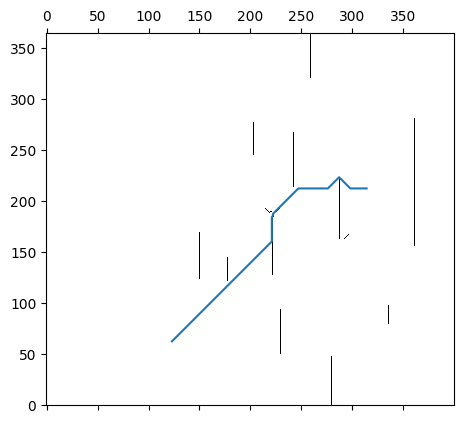

In [21]:
plot(env, euclidean_path)

In [19]:
# Make sure the optimal path did not go through obstacle
numrows, numcols = env.shape
obstacles = [(r,c) for r in range(numrows) for c in range(numcols) if env[r,c] == 1]
intersection = check_common(obstacles, euclidean_path)
print(f'Number of common coordinates between obstacles and optimal path:{len(intersection)}')

Number of common coordinates between obstacles and optimal path:0


In [20]:
# Perform A* search on data 1 map using Manhattan Distance Heuristic
manhattan_path, manhattan_visited, manhattan_cost, manhattan_time = run_astar(env, start, points, 'manhattan')
print(f"\nData 1 Map running time using Manhattan Distance is {manhattan_time} seconds")

Found Target:  (314, 212)
Cost to find the current target is: 2754

Data 1 Map running time using Manhattan Distance is 0.6355459690093994 seconds


In [21]:
# Show the optimal path
print(f"Using Manhattan Heuristic Function, we have visited {manhattan_visited} position.")
print("\nLength of Optimal Path:", len(manhattan_path))
print("\nCost of Optimal Path using Manhattan Heuristic Function:", calculate_cost(manhattan_path))

Using Manhattan Heuristic Function, we have visited 1206 position.

Length of Optimal Path: 218

Cost of Optimal Path using Manhattan Heuristic Function: 2754


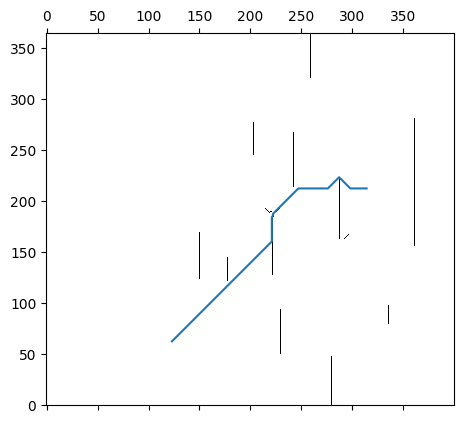

In [22]:
plot(env, manhattan_path)

In [23]:
# Make sure the optimal path did not went through obstacles
numrows, numcols = env.shape
obstacles = [(r,c) for r in range(numrows) for c in range(numcols) if env[r,c] == 1]
intersection = check_common(obstacles, manhattan_path)
print(f'Number of common coordinates between obstacles and optimal path: {len(intersection)}')

Number of common coordinates between obstacles and optimal path: 0


In [24]:
print("Using Euclidean Heuristic Function, the length of optimal path is:", len(euclidean_path))
print("Using Manhattan Heuristic Function, the length of optimal path is:", len(manhattan_path))

Using Euclidean Heuristic Function, the length of optimal path is: 218
Using Manhattan Heuristic Function, the length of optimal path is: 218


Both Euclidean and Manhattan Heuristic Function will provide the same optimal path. The cost of the optimal path is also the same. Therefore, we can conclude that both heuristic function will provide the same and consistent results.

However, Manhattan Heuristic Function explored less nodes than Euclidean Heuristic Function.

<a id = "competition_map"></a></a><div style="text-align: right"> <a href=#Table_of_content>Back?</a> </div>
# A* Path Finding on Competition Maps

Here, we will perform A* Search using Euclidean Heuristic Function and Manhattan Heuristic Function on the competition map.

<a id = "round_1"></a>
### Round 1 Map

In [25]:
round_1 = create_environment('round_1.txt')

The shape of the environment array is : (400, 365)


In [26]:
# get starting point and targets
start = ind(round_1, 2)
print("Starting point: ", start)
numrows, numcols = round_1.shape
points = [(r,c) for r in range(numrows) for c in range(numcols) if round_1[r,c] == 3]
print("Targets: ", points)

Starting point:  (314, 212)
Targets:  [(53, 276)]


In [27]:
round_1 = environment_setup(round_1)

In [28]:
# Perform A* search on round 1 map using Euclidean Distance Heuristic
euclidean_round_1_path, euclidean_round_1_visited, euclidean_round_1_cost, euclidean_round_1_time = run_astar(round_1, start, points, 'euclidean')
print(f"\nRound 1 running time using Euclidean Distance is {euclidean_round_1_time} seconds")

Found Target:  (53, 276)
Cost to find the current target is: 2962

Round 1 running time using Euclidean Distance is 18.082518100738525 seconds


In [29]:
euclidean_round_1_path = list(dict.fromkeys(euclidean_round_1_path))
print("Length of Optimal Path for Round 1 Competition Map using Euclidean Distance:", len(euclidean_round_1_path))
print("Cost of Optimal Path for Round 1 Competition Map using Euclidean Distance:", euclidean_round_1_cost)
print("Number of nodes explored for Round 1 Competition Map using Euclidean Distance:", euclidean_round_1_visited)

Length of Optimal Path for Round 1 Competition Map using Euclidean Distance: 262
Cost of Optimal Path for Round 1 Competition Map using Euclidean Distance: 2962
Number of nodes explored for Round 1 Competition Map using Euclidean Distance: 6948


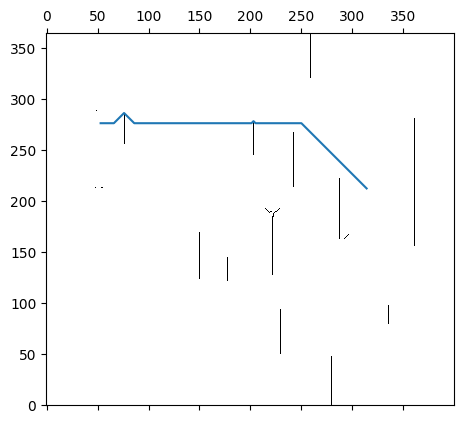

In [30]:
plot(round_1, euclidean_round_1_path)

In [31]:
# Perform A* search on round 1 map using Manhattan Distance Heuristic
manhattan_round_1_path, manhattan_round_1_visited, manhattan_round_1_cost, manhattan_round_1_time = run_astar(round_1, start, points, 'manhattan')
print(f"\nRound 1 running time using Manhattan Distance is {manhattan_round_1_time} seconds")

Found Target:  (53, 276)
Cost to find the current target is: 2962

Round 1 running time using Manhattan Distance is 5.507334232330322 seconds


In [32]:
manhattan_round_1_path = list(dict.fromkeys(manhattan_round_1_path))
print("Length of Optimal Path for Round 1 Competition Map using Manhattan Distance:", len(manhattan_round_1_path))
print("Cost of Optimal Path for Round 1 Competition Map using Manhattan Distance:", manhattan_round_1_cost)
print("Number of nodes explored for Round 1 Competition Map using Manhattan Distance:", manhattan_round_1_visited)

Length of Optimal Path for Round 1 Competition Map using Manhattan Distance: 262
Cost of Optimal Path for Round 1 Competition Map using Manhattan Distance: 2962
Number of nodes explored for Round 1 Competition Map using Manhattan Distance: 3781


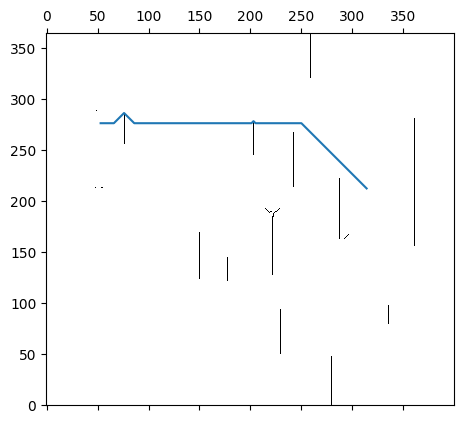

In [33]:
plot(round_1, manhattan_round_1_path)

In [34]:
# Make sure the optimal path did not go through obstacle
numrows, numcols = round_1.shape
obstacles = [(r,c) for r in range(numrows) for c in range(numcols) if round_1[r,c] == 1]
euclidean_intersection = check_common(obstacles, euclidean_round_1_path)
manhattan_intersection = check_common(obstacles, manhattan_round_1_path)
print(f'Number of common coordinates between obstacles and optimal path using Euclidean Distance: {len(euclidean_intersection)}')
print(f'Number of common coordinates between obstacles and optimal path using Manhattan Distance: {len(manhattan_intersection)}')

Number of common coordinates between obstacles and optimal path using Euclidean Distance: 0
Number of common coordinates between obstacles and optimal path using Manhattan Distance: 0


<a id = "round_2"></a>
### Round 2 Map

In [35]:
round_2 = create_environment('round_2.txt')

The shape of the environment array is : (400, 365)


In [36]:
# get starting point and targets
numrows, numcols = round_2.shape
start = ind(round_2, 2)
points = [(r,c) for r in range(numrows) for c in range(numcols) if round_2[r,c] == 3]
print("Starting point: ", start)
print("Targets: ", points)

Starting point:  (222, 248)
Targets:  [(51, 231), (247, 53)]


In [37]:
round_2 = environment_setup(round_2)

In [38]:
# Perform A* search on round 2 map using Euclidean Distance Heuristic
euclidean_round_2_path, euclidean_round_2_visited, euclidean_round_2_cost, euclidean_round_2_time = run_astar(round_2, start, points, 'euclidean')
print(f"\nRound 2 running time using Euclidean Distance is {euclidean_round_2_time} seconds")

Found Target:  (51, 231)
Cost to find the current target is: 1778
Found Target:  (247, 53)
Cost to find the current target is: 2758

Round 2 running time using Euclidean Distance is 0.13261699676513672 seconds


In [39]:
euclidean_round_2_path = list(dict.fromkeys(euclidean_round_2_path))
euclidean_round_2_visited = euclidean_round_2_visited - 1
print("Length of Optimal Path for Round 2 Competition Map using Euclidean Distance:", len(euclidean_round_2_path))
print("Cost of Optimal Path for Round 2 Competition Map using Euclidean Distance:", euclidean_round_2_cost)
print("Number of nodes explored for Round 2 Competition Map using Euclidean Distance:", euclidean_round_2_visited)

Length of Optimal Path for Round 2 Competition Map using Euclidean Distance: 377
Cost of Optimal Path for Round 2 Competition Map using Euclidean Distance: 4536
Number of nodes explored for Round 2 Competition Map using Euclidean Distance: 502


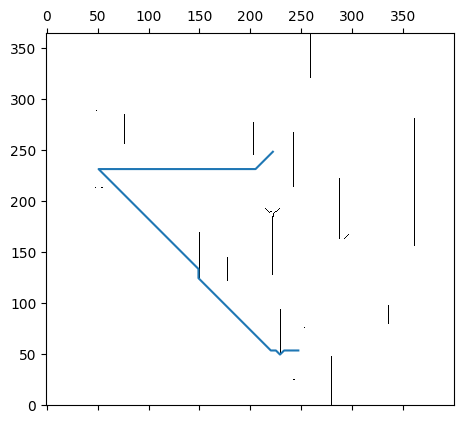

In [40]:
plot(round_2, euclidean_round_2_path)

In [41]:
# Perform A* search on round 2 map using Manhattan Distance Heuristic
manhattan_round_2_path, manhattan_round_2_visited, manhattan_round_2_cost, manhattan_round_2_time = run_astar(round_2, start, points, 'manhattan')
print(f"\nRound 2 running time using Manhattan Distance is {manhattan_round_2_time} seconds")

Found Target:  (51, 231)
Cost to find the current target is: 1778
Found Target:  (247, 53)
Cost to find the current target is: 2758

Round 2 running time using Manhattan Distance is 0.09071230888366699 seconds


In [42]:
manhattan_round_2_path = list(dict.fromkeys(manhattan_round_2_path))
manhattan_round_2_visited = manhattan_round_2_visited - 1
print("Length of Optimal Path for Round 2 Competition Map using Manhattan Distance:", len(manhattan_round_2_path))
print("Cost of Optimal Path for Round 2 Competition Map using Manhattan Distance:", manhattan_round_2_cost)
print("Number of nodes explored for Round 2 Competition Map using Manhattan Distance:", manhattan_round_2_visited)

Length of Optimal Path for Round 2 Competition Map using Manhattan Distance: 377
Cost of Optimal Path for Round 2 Competition Map using Manhattan Distance: 4536
Number of nodes explored for Round 2 Competition Map using Manhattan Distance: 461


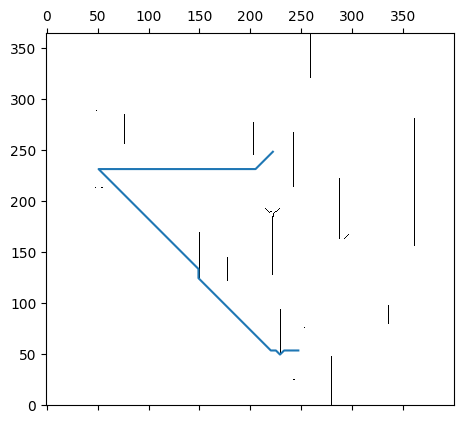

In [43]:
plot(round_2, manhattan_round_2_path)

In [44]:
# Make sure the optimal path did not go through obstacle
numrows, numcols = round_2.shape
obstacles = [(r,c) for r in range(numrows) for c in range(numcols) if round_2[r,c] == 1]
euclidean_intersection = check_common(obstacles, euclidean_round_2_path)
manhattan_intersection = check_common(obstacles, manhattan_round_2_path)
print(f'Number of common coordinates between obstacles and optimal path using Euclidean Distance: {len(euclidean_intersection)}')
print(f'Number of common coordinates between obstacles and optimal path using Manhattan Distance: {len(manhattan_intersection)}')

Number of common coordinates between obstacles and optimal path using Euclidean Distance: 0
Number of common coordinates between obstacles and optimal path using Manhattan Distance: 0


<a id = "round_3"></a>
### Round 3 Map

In [45]:
round_3 = create_environment('round_3.txt')

The shape of the environment array is : (400, 365)


In [46]:
# get starting point and targets
numrows, numcols = round_3.shape
start = ind(round_3, 2)
points = [(r,c) for r in range(numrows) for c in range(numcols) if round_3[r,c] == 3]
print("Starting point: ", start)
print("Targets: ", points)

Starting point:  (192, 125)
Targets:  [(52, 88), (294, 200), (376, 226)]


In [47]:
round_3 = environment_setup(round_3)

In [52]:
# Perform A* search on round 3 map using Euclidean Distance Heuristic
euclidean_round_3_path, euclidean_round_3_visited, euclidean_round_3_cost, euclidean_round_3_time = run_astar(round_3, start, points, 'euclidean')
print(f"\nRound 3 running time using Euclidean Distance is {euclidean_round_3_time} seconds")

Found Target:  (52, 88)
Cost to find the current target is: 1668
Found Target:  (294, 200)
Cost to find the current target is: 3196
Found Target:  (376, 226)
Cost to find the current target is: 1708

Round 3 running time using Euclidean Distance is 249.77783823013306 seconds


In [49]:
euclidean_round_3_path = list(dict.fromkeys(euclidean_round_3_path))
euclidean_round_3_visited = euclidean_round_3_visited - 2
print("Length of Optimal Path for Round 3 Competition Map using Euclidean Distance:", len(euclidean_round_3_path))
print("Cost of Optimal Path for Round 3 Competition Map using Euclidean Distance:", euclidean_round_3_cost)
print("Number of nodes explored for Round 3 Competition Map using Euclidean Distance:", euclidean_round_3_visited)

Length of Optimal Path for Round 3 Competition Map using Euclidean Distance: 545
Cost of Optimal Path for Round 3 Competition Map using Euclidean Distance: 6572
Number of nodes explored for Round 3 Competition Map using Euclidean Distance: 28246


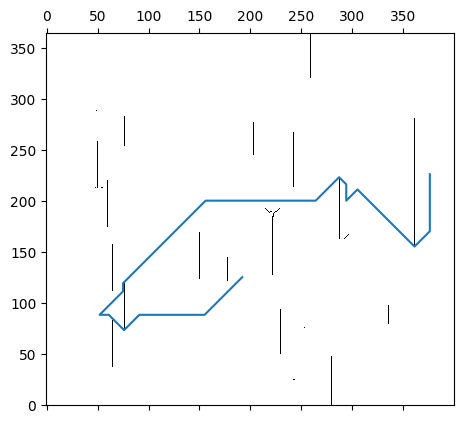

In [50]:
plot(round_3, euclidean_round_3_path)

In [53]:
# Perform A* search on round 3 map using Manhattan Distance Heuristic
manhattan_round_3_path, manhattan_round_3_visited, manhattan_round_3_cost, manhattan_round_3_time = run_astar(round_3, start, points, 'manhattan')
print(f"\nRound 3 running time using Manhattan Distance is {manhattan_round_3_time} seconds")

Found Target:  (52, 88)
Cost to find the current target is: 1668
Found Target:  (294, 200)
Cost to find the current target is: 3196
Found Target:  (376, 226)
Cost to find the current target is: 1708

Round 3 running time using Manhattan Distance is 78.52897119522095 seconds


In [54]:
manhattan_round_3_path = list(dict.fromkeys(manhattan_round_3_path))
manhattan_round_3_visited = manhattan_round_3_visited - 2
print("Length of Optimal Path for Round 3 Competition Map using Manhattan Distance:", len(manhattan_round_3_path))
print("Cost of Optimal Path for Round 3 Competition Map using Manhattan Distance:", manhattan_round_3_cost)
print("Number of nodes explored for Round 3 Competition Map using Manhattan Distance:", manhattan_round_3_visited)

Length of Optimal Path for Round 3 Competition Map using Manhattan Distance: 545
Cost of Optimal Path for Round 3 Competition Map using Manhattan Distance: 6572
Number of nodes explored for Round 3 Competition Map using Manhattan Distance: 17327


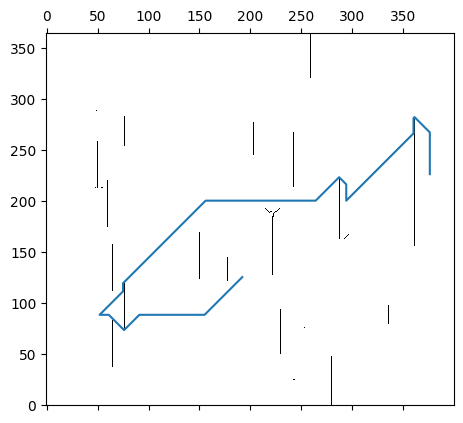

In [55]:
plot(round_3, manhattan_round_3_path)

In [56]:
# Make sure the optimal path did not go through obstacle
numrows, numcols = round_3.shape
obstacles = [(r,c) for r in range(numrows) for c in range(numcols) if round_3[r,c] == 1]
euclidean_intersection = check_common(obstacles, euclidean_round_3_path)
manhattan_intersection = check_common(obstacles, manhattan_round_3_path)
print(f'Number of common coordinates between obstacles and optimal path using Euclidean Distance: {len(euclidean_intersection)}')
print(f'Number of common coordinates between obstacles and optimal path using Manhattan Distance: {len(euclidean_intersection)}')

Number of common coordinates between obstacles and optimal path using Euclidean Distance: 0
Number of common coordinates between obstacles and optimal path using Manhattan Distance: 0
